In [57]:
# make sure you don't hog all the video memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################

from keras.layers import Input, Lambda, merge, Dense, DepthwiseConv2D, Activation, AveragePooling2D
from keras.layers import Flatten,Conv2D, MaxPooling2D, Dropout, BatchNormalization, SeparableConv2D
from keras.constraints import max_norm
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.initializers import RandomUniform
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline

In [2]:
SHUFFLE = False
Seed = 4
SCRAMBLE_FOR_TEST = False
AUGMENT = True

file = 'Merged456-197-289_ICA(-eyes)+AUDpreproc.mat, DS2=64Hz, FIR=2-30Hz, centnorm=1, step=2, win=2, TD, 1-93.mat' #0.75(vanilla EEGnet), 0. (SiameseL1)
# file = 'Merged456-1-94_ICA(-2,3ICs)+AUDpreproc.mat, DS2=64Hz, FIR=2-30Hz, centnorm=1, step=2, win=2, TD, 1-95.mat' #0.61(vanilla EEGnet)
# get the Dataset:
import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

path = '/home/amplifier/home/DATASETS/' + file
mat_contents = sio.loadmat(path)
X = mat_contents['X']
Y = mat_contents['Z']

if X.shape[1]<X.shape[2]:
    X = np.transpose(X,[0,2,1])

if Y.shape[1] > Y.shape[0]:
    Y = Y.T

    
# # one hot encode the labels:
# onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
# Y = onehot_encoder.fit_transform(Y)

X = X.transpose(0,2,1)

print('Original data shape:', X.shape)
print('Original labels shape:', Y.shape)


# verify that the model REALLY finds a mapping between the input and the labels. If we get
# our accuracy by chance, then we should get the same accuracy on a permuted dataset:
if SCRAMBLE_FOR_TEST==True:
    Y = np.random.permutation(Y)
Y = Y.flatten()

Original data shape: (450, 60, 128)
Original labels shape: (450, 1)


In [3]:
from itertools import product
from sys import getsizeof

    
def get_pairs(X,Y):
    print('X', X.shape)
    print('Y', Y.shape)
    
    # get the full permutation (very LARGE DATASET!)

    temp = []
    for x in product(range(Y.shape[0]), repeat=2):
        temp.append(np.array(x))
    
    n_perm = len(temp)
    temp = np.array(temp)
    print('temp', temp.shape)

    XX = np.zeros([n_perm,2,60,128])
    XX[:,0,:,:] = X[[temp[i,0] for i in range(n_perm)],:,:]
    XX[:,1,:,:] = X[[temp[i,1] for i in range(n_perm)],:,:]

    print('Data size in memory (GB):', np.round(getsizeof(XX)/1024/1024/1024, 2))

    YY = np.zeros([n_perm, 2])
    YY[:,0] = Y[[temp[i,0] for i in range(n_perm)]].flatten()
    YY[:,1] = Y[[temp[i,1] for i in range(n_perm)]].flatten()

    YYY = []
    for i in range(len(YY)):
        YYY.append(0 if YY[i,0]==YY[i,1] else 1)
    YYY = np.array(YYY).flatten()
    
    # diag:
#     print (XX.shape, YYY.shape)
#     for i in range(XX.shape[0]):
#         print(temp[i,0], YY[i,0], temp[i,1], YY[i,1], YYY[i])

    print('Left Col', np.mean(YY[:,0]))
    print('Right Col', np.mean(YY[:,1]))
    print('Labels', np.mean(YYY), '\n')
    
    print("\nPairs", XX.shape)
    print("Labels", YYY.shape)
    
    return XX, YYY

In [4]:
x_train, x_test, y_train, y_test, = train_test_split(X, Y, test_size=0.1, shuffle=True)

print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

(405, 60, 128)
(45, 60, 128)
(405,)
(45,)


In [5]:
X_test, Y_test = get_pairs(x_test, y_test)
X_train, Y_train = get_pairs(x_train, y_train)

X (45, 60, 128)
Y (45,)
temp (2025, 2)
Data size in memory (GB): 0.23
Left Col 0.5777777777777777
Right Col 0.5777777777777777
Labels 0.48790123456790124 


Pairs (2025, 2, 60, 128)
Labels (2025,)
X (405, 60, 128)
Y (405,)
temp (164025, 2)
Data size in memory (GB): 18.77
Left Col 0.49135802469135803
Right Col 0.49135802469135803
Labels 0.49985063252552964 


Pairs (164025, 2, 60, 128)
Labels (164025,)


In [6]:
# print(X.shape)
# val_set = np.random.choice(range(len(Y)), 50, replace=False)
# print(val_set.shape)
# X_val = X[val_set,:,:]
# Y_val = Y[val_set]
# print('Validation Set')
# print('X_val:', X_val.shape)
# print('Y_val:', Y_val.shape)

# X = np.delete(X,val_set,0)
# Y = np.delete(Y,val_set,0)
# print('Train & Test')
# print(X.shape)
# print(Y.shape)

In [7]:
# SZ = 195
# idx_a = []
# idx_b = []
# idy_a = []
# idy_b = []
# YYY = []
# for i in range(2):
#     addr = np.array(np.where(Y==i)).flatten()
#     a = np.random.choice(addr, size=SZ, replace=False).tolist()
#     b = np.random.choice(addr, size=SZ, replace=False).tolist()
#     idx_a = idx_a + a
#     idx_b = idx_b + b
#     idy_a = idy_a + a
#     idy_b = idy_b + b

# for i in range(2):
#     addr_a = np.array(np.where(Y==i)).flatten()
#     addr_b = np.array(np.where(Y!=i)).flatten()
#     a = np.random.choice(addr_a, size=SZ, replace=False).tolist()
#     b = np.random.choice(addr_b, size=SZ, replace=False).tolist()
#     idx_a = idx_a + a
#     idx_b = idx_b + b
#     idy_a = idy_a + a
#     idy_b = idy_b + b
    
# XX = [X[idx_a], X[idx_b]]
# YY = [Y[idy_a], Y[idy_b]]

# for i in range(len(idx_a)):
#     YYY.append(0 if YY[0][i]==YY[1][i] else 1)
# YYY = np.array(YYY)

In [8]:
# for i in range(len(idy_a)):
#     print(i, idy_a[i], idy_b[i], YY[0][i], YY[1][i], YYY[i])

In [9]:
# rng = np.arange(len(idx_a))
# train_test = 0.8

# # sample ordinal numbers of 
# train_id = np.random.choice(rng ,np.round(len(rng)*train_test).astype('int64'), replace=False)
# test_id = rng[np.isin(rng,train_id, invert=True)]

# x_train = [X[np.array(idx_a)[train_id]], X[np.array(idx_b)[train_id]]]
# x_test = [X[np.array(idx_a)[test_id]], X[np.array(idx_b)[test_id]]]
# y_train = YYY[train_id]
# y_test = YYY[test_id]

# print(len(idx_a))
# print(len(y_train))
# print(len(y_test))

# print(np.mean(y_train))
# print(np.mean(y_test))

# x_train = np.array(x_train).transpose(1,0,2,3)
# x_test = np.array(x_test).transpose(1,0,2,3)
# y_train = np.array(y_train).flatten()
# y_test = np.array(y_test).flatten()

In [10]:
# # get the full permutation (very LARGE DATASET!)
# from itertools import product
# from sys import getsizeof

# temp = []
# for x in product(range(Y.shape[0]), repeat=2):
#     temp.append(np.array(x))

# XX = np.zeros([len(temp), 2, 60, 128])
# XX[:,0,:,:] = X[[temp[i][0] for i in range(len(temp))],:,:]
# XX[:,1,:,:] = X[[temp[i][1] for i in range(len(temp))],:,:]


# print('Data size in memory (GB):', np.round(getsizeof(XX)/1024/1024/1024, 2))

# YY = np.zeros([len(temp), 2])
# YY[:,0] = Y[[temp[i][0] for i in range(len(temp))]].flatten()
# YY[:,1] = Y[[temp[i][1] for i in range(len(temp))]].flatten()

# YYY = []
# for i in range(len(YY)):
#     YYY.append(1 if YY[i,0]==YY[i,1] else 0)
# YYY = np.array(YYY).flatten()

# x_train, x_test, y_train, y_test = train_test_split(XX,YYY, test_size=0.1, shuffle=True, random_state=10)
# print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

In [6]:
def EEGNet_my(input1, nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.25, kernLength = 64, F1 = 4, 
             D = 2, F2 = 8, dropoutType = 'Dropout'):
    
    """ Keras Implementation of EEGNet (https://arxiv.org/abs/1611.08024)

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 4, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    init = RandomUniform(minval=-0.1, maxval=0.1, seed=29)
    net = Sequential()
    net.add (Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples,1),
                                   use_bias = False, bias_initializer=init, kernel_initializer=init))
    net.add (BatchNormalization())
    net.add (DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.), bias_initializer=init, kernel_initializer=init))
    net.add (BatchNormalization())
    net.add (Activation('elu'))
    net.add (AveragePooling2D((1, 4)))
    net.add (dropoutType(dropoutRate))
    net.add (SeparableConv2D(F2, (1, 16), use_bias = False, padding = 'same', bias_initializer=init, kernel_initializer=init))
    net.add (BatchNormalization())
    net.add (Activation('elu'))
    net.add (AveragePooling2D((1, 8)))
    net.add (dropoutType(dropoutRate))
    net.add (Flatten())
    net.add (Dense(nb_classes, kernel_constraint = max_norm(0.25), bias_initializer=init, kernel_initializer=init))
    return net

In [23]:
from keras.engine.topology import Layer
from keras.layers import Concatenate

# def triplet_loss(y_true, y_pred):
#     norm1 = K.sqrt(K.sum(K.square(y_pred[0] - y_pred[1]), axis=-1, keepdims=True))
#     norm2 = K.sqrt(K.sum(K.square(y_pred[0] - y_pred[2]), axis=-1, keepdims=True))
#     loss = norm1 - norm2 + 0.2
#     return loss

input_shape = X_train[-1,-1,:,:].shape + (1,)
a_input = Input(input_shape)
r_input = Input(input_shape)

#call the convnet Sequential model on each of the input tensors so params will be shared
# encoded NOT as Sequential (stack of layers), but as a Tensor!!!! if you add an argument, a Tensor is returned
encoded_a = EEGNet_my(input_shape, 10, Chans=input_shape[0])(a_input)
encoded_r = EEGNet_my(input_shape, 10, Chans=input_shape[0])(r_input)

L1_distance = Lambda(lambda tensors: (K.abs(tensors[0] - tensors[1])))([encoded_a, encoded_r])
L1_distance = Dense(1,activation='sigmoid', use_bias=True)(L1_distance)

# siamese_net = Model(inputs=[a_input, r_input], outputs=[encoded_a, encoded_r, L1_distance])
siamese_net = Model(inputs=[a_input, r_input], outputs=[L1_distance])
optimizer = Adam(0.00003)
# optimizer = 'adam'
siamese_net.compile(loss=['binary_crossentropy'], optimizer=optimizer, metrics=['accuracy'])
siamese_net.summary()

a1 = np.linalg.norm(siamese_net.layers[2].layers[13].get_weights()[0])
a2 = np.linalg.norm(siamese_net.layers[3].layers[13].get_weights()[0])
print(a1, a2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 60, 128, 1)   0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 60, 128, 1)   0                                            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 10)           1338        input_7[0][0]                    
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 10)           1338        input_8[0][0]                    
__________________________________________________________________________________________________
lambda_4 (

In [24]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_acc', patience=40, mode='min')
checkpointer = ModelCheckpoint(filepath='/home/amplifier/home/NEW_DL/weights/Siam3_wts.h5',
                               verbose=1,
                               monitor='val_acc',
                               save_best_only=True)

train_history = siamese_net.fit([X_train[:,0,:,:,None], X_train[:,1,:,:,None]], Y_train,
                epochs=100,
                batch_size=50,
                verbose=1,
                shuffle=True,
                validation_data=([X_test[:,0,:,:,None], X_test[:,1,:,:,None]], Y_test),
                callbacks=[checkpointer, early_stopping])

# model.save('/home/amplifier/home/NEW_DL/models/Siam3.h5')

Train on 164025 samples, validate on 2025 samples
Epoch 1/100
164025/164025 [==============================] - 363s 2ms/step - loss: 0.6948 - acc: 0.5009 - val_loss: 0.6938 - val_acc: 0.4948

Epoch 00001: val_acc improved from -inf to 0.49481, saving model to /home/amplifier/home/NEW_DL/weights/Siam3_wts.h5
Epoch 2/100
 68300/164025 [===========>..................] - ETA: 1:41 - loss: 0.6940 - acc: 0.4985

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



164025/164025 [==============================] - 64s 388us/step - loss: 0.6933 - acc: 0.5039 - val_loss: 0.6941 - val_acc: 0.4884

Epoch 00005: val_acc did not improve from 0.49728
Epoch 6/100
164025/164025 [==============================] - 64s 389us/step - loss: 0.6933 - acc: 0.5028 - val_loss: 0.6939 - val_acc: 0.4869

Epoch 00006: val_acc did not improve from 0.49728
Epoch 7/100
129150/164025 [======================>.......] - ETA: 13s - loss: 0.6931 - acc: 0.5044

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



164025/164025 [==============================] - 66s 404us/step - loss: 0.6915 - acc: 0.5218 - val_loss: 0.6941 - val_acc: 0.4775

Epoch 00011: val_acc did not improve from 0.49728
Epoch 12/100
164025/164025 [==============================] - 66s 405us/step - loss: 0.6889 - acc: 0.5403 - val_loss: 0.6942 - val_acc: 0.4973

Epoch 00012: val_acc did not improve from 0.49728
Epoch 13/100
164025/164025 [==============================] - 66s 400us/step - loss: 0.6811 - acc: 0.5662 - val_loss: 0.6882 - val_acc: 0.5526

Epoch 00013: val_acc improved from 0.49728 to 0.55259, saving model to /home/amplifier/home/NEW_DL/weights/Siam3_wts.h5
Epoch 14/100
 19550/164025 [==>...........................] - ETA: 56s - loss: 0.6700 - acc: 0.5936

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



164025/164025 [==============================] - 67s 406us/step - loss: 0.5992 - acc: 0.6782 - val_loss: 0.6960 - val_acc: 0.5817

Epoch 00017: val_acc improved from 0.55951 to 0.58173, saving model to /home/amplifier/home/NEW_DL/weights/Siam3_wts.h5
Epoch 18/100
164025/164025 [==============================] - 66s 404us/step - loss: 0.5806 - acc: 0.6952 - val_loss: 0.7001 - val_acc: 0.5926

Epoch 00018: val_acc improved from 0.58173 to 0.59259, saving model to /home/amplifier/home/NEW_DL/weights/Siam3_wts.h5
Epoch 19/100
164025/164025 [==============================] - 66s 404us/step - loss: 0.5595 - acc: 0.7136 - val_loss: 0.6996 - val_acc: 0.6104

Epoch 00019: val_acc improved from 0.59259 to 0.61037, saving model to /home/amplifier/home/NEW_DL/weights/Siam3_wts.h5
Epoch 20/100
 98000/164025 [================>.............] - ETA: 26s - loss: 0.5399 - acc: 0.7302

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



164025/164025 [==============================] - 104s 636us/step - loss: 0.4737 - acc: 0.7774 - val_loss: 0.7446 - val_acc: 0.5798

Epoch 00023: val_acc did not improve from 0.61037
Epoch 24/100
164025/164025 [==============================] - 106s 646us/step - loss: 0.4517 - acc: 0.7917 - val_loss: 0.7499 - val_acc: 0.5872

Epoch 00024: val_acc did not improve from 0.61037
Epoch 25/100
 88000/164025 [===============>..............] - ETA: 49s - loss: 0.4313 - acc: 0.8060

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



164025/164025 [==============================] - 106s 649us/step - loss: 0.3728 - acc: 0.8396 - val_loss: 0.7920 - val_acc: 0.5719

Epoch 00028: val_acc did not improve from 0.61037
Epoch 29/100
164025/164025 [==============================] - 107s 652us/step - loss: 0.3538 - acc: 0.8505 - val_loss: 0.8150 - val_acc: 0.5575

Epoch 00029: val_acc did not improve from 0.61037
Epoch 30/100
  5800/164025 [>.............................] - ETA: 1:42 - loss: 0.3323 - acc: 0.8653- ETA: 1:46 - los

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



164025/164025 [==============================] - 92s 561us/step - loss: 0.3059 - acc: 0.8747 - val_loss: 0.8513 - val_acc: 0.5714

Epoch 00032: val_acc did not improve from 0.61037
Epoch 33/100
164025/164025 [==============================] - 66s 405us/step - loss: 0.2929 - acc: 0.8807 - val_loss: 0.8597 - val_acc: 0.5723

Epoch 00033: val_acc did not improve from 0.61037
Epoch 34/100
164025/164025 [==============================] - 67s 406us/step - loss: 0.2777 - acc: 0.8886 - val_loss: 0.8918 - val_acc: 0.5714

Epoch 00034: val_acc did not improve from 0.61037
Epoch 35/100
 15500/164025 [=>............................] - ETA: 1:00 - loss: 0.2685 - acc: 0.8934

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



164025/164025 [==============================] - 66s 404us/step - loss: 0.2320 - acc: 0.9106 - val_loss: 0.9774 - val_acc: 0.5931

Epoch 00038: val_acc did not improve from 0.61037
Epoch 39/100
164025/164025 [==============================] - 66s 405us/step - loss: 0.2226 - acc: 0.9144 - val_loss: 0.9735 - val_acc: 0.5960

Epoch 00039: val_acc did not improve from 0.61037
Epoch 40/100
164025/164025 [==============================] - 66s 402us/step - loss: 0.2141 - acc: 0.9194 - val_loss: 1.0084 - val_acc: 0.5965

Epoch 00040: val_acc did not improve from 0.61037
Epoch 41/100
101150/164025 [=================>............] - ETA: 25s - loss: 0.2063 - acc: 0.9220

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



164025/164025 [==============================] - 66s 404us/step - loss: 0.1735 - acc: 0.9368 - val_loss: 1.1250 - val_acc: 0.5926

Epoch 00045: val_acc did not improve from 0.61037
Epoch 46/100
164025/164025 [==============================] - 66s 405us/step - loss: 0.1643 - acc: 0.9410 - val_loss: 1.1816 - val_acc: 0.5857

Epoch 00046: val_acc did not improve from 0.61037
Epoch 47/100
164025/164025 [==============================] - 66s 404us/step - loss: 0.1591 - acc: 0.9430 - val_loss: 1.2006 - val_acc: 0.5664

Epoch 00047: val_acc did not improve from 0.61037
Epoch 48/100
 34750/164025 [=====>........................] - ETA: 51s - loss: 0.1585 - acc: 0.9430

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [30]:
siamese_net.load_weights('/home/amplifier/home/NEW_DL/weights/Siam3_wts.h5')

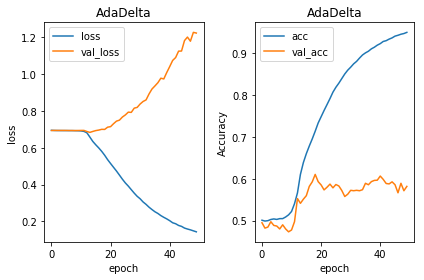

In [25]:
# print(np.array(history.losses))
import matplotlib.pyplot as plt
%matplotlib inline
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

plt.subplot(121)
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.title('AdaDelta')
plt.ylabel('loss')
plt.xlabel('epoch')

acc = train_history.history['acc']
val_acc = train_history.history['val_acc']

plt.subplot(122)
plt.plot(acc)
plt.plot(val_acc)
plt.legend(['acc', 'val_acc'])
plt.title('AdaDelta')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.tight_layout()

In [31]:
train_acc = []
rng = np.random.choice(Y_train.shape[0], 195, replace=False)
prediction = []
for i in rng:
    pred = siamese_net.predict([X_train[None,i,0,:,:,None], X_train[None,i,1,:,:,None]])
    prediction.append(pred)
    acc = 'correct' if np.round(pred)==Y_train[i] else ""
    train_acc.append(1 if np.round(pred)==Y_train[i] else 0)
#     print(i, pred, np.round(pred), y_train[i], acc)
print('Train Accuracy', np.mean(train_acc))

Train Accuracy 0.8051282051282052


In [35]:
test_acc = []
rng = np.random.choice(Y_test.shape[0], 190, replace=False)
prediction = []
for i in rng:
    pred = siamese_net.predict([X_test[None,i,0,:,:,None], X_test[None,i,1,:,:,None]])
    prediction.append(pred)
    acc = 'correct' if np.round(pred)==Y_test[i] else ""
    test_acc.append(1 if np.round(pred)==Y_test[i] else 0)
#     print(i, pred, np.round(pred), y_test[i], acc)
print('Test Accuracy', np.mean(test_acc))

Test Accuracy 0.6105263157894737


In [192]:
val_acc = []
for k in range(len(Y_val)):
    i = np.random.randint(len(Y_val))
    j = np.random.randint(len(Y_val))
    pred = siamese_net.predict([X_val[None,i,:,:,None], X_val[None,j,:,:,None]])
    correct = 1 if Y_val[i]==Y_val[j] and np.round(pred)==0 or Y_val[i]!=Y_val[j] and np.round(pred)==1  else 0
    val_acc.append(correct)
    print(i, pred, Y_val[i], Y_val[j], correct)
print('Validation accuracy:', np.mean(val_acc))

3 [[0.9992372]] [1] [1] 0
7 [[0.00024588]] [1] [1] 1
21 [[0.46680015]] [0] [0] 1
14 [[0.01244232]] [1] [0] 0
36 [[0.04232696]] [1] [0] 0
29 [[0.99990094]] [1] [0] 1
19 [[0.1772979]] [1] [1] 1
12 [[0.9069365]] [1] [1] 0
37 [[0.7378922]] [0] [1] 1
36 [[0.29272014]] [1] [1] 1
15 [[0.04256096]] [0] [0] 1
28 [[0.53658324]] [0] [0] 0
29 [[0.9999231]] [1] [0] 1
18 [[0.00088351]] [0] [1] 0
30 [[0.9805331]] [0] [0] 0
10 [[0.9360994]] [0] [0] 0
18 [[0.99991226]] [0] [0] 0
44 [[0.00152636]] [1] [0] 0
37 [[0.9978452]] [0] [0] 0
47 [[0.78717244]] [0] [0] 0
2 [[0.9994961]] [0] [1] 1
12 [[0.8994222]] [1] [1] 0
41 [[0.7775418]] [1] [1] 0
36 [[0.99999964]] [1] [1] 0
35 [[0.00529279]] [1] [1] 1
0 [[0.9932267]] [0] [0] 0
8 [[0.9999838]] [0] [1] 1
28 [[0.00052391]] [0] [1] 0
8 [[0.9998846]] [0] [1] 1
18 [[0.9999815]] [0] [1] 1
12 [[0.46604905]] [1] [0] 0
3 [[0.8300947]] [1] [1] 0
25 [[0.00095356]] [1] [1] 1
43 [[0.9842917]] [1] [1] 0
11 [[8.524662e-05]] [0] [0] 1
3 [[0.9992888]] [1] [1] 0
44 [[0.9985189]]

In [53]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.25, kernLength = 64, F1 = 4, 
             D = 2, F2 = 8, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet (https://arxiv.org/abs/1611.08024)

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 4, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (1, Chans, Samples))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (1, Chans, Samples),
                                   use_bias = False, data_format='channels_first')(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.), data_format='channels_first')(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4), data_format='channels_first')(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False,
                                   padding = 'same',
                                   data_format='channels_first')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8), data_format='channels_first')(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(0.25))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

model  = EEGNet(nb_classes = 2,
                Chans = 60,
                Samples = 128,
                kernLength = 125)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 1, 60, 128)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 60, 128)        500       
_________________________________________________________________
batch_normalization_28 (Batc (None, 4, 60, 128)        16        
_________________________________________________________________
depthwise_conv2d_10 (Depthwi (None, 8, 1, 128)         480       
_________________________________________________________________
batch_normalization_29 (Batc (None, 8, 1, 128)         32        
_________________________________________________________________
activation_15 (Activation)   (None, 8, 1, 128)         0         
_________________________________________________________________
average_pooling2d_14 (Averag (None, 8, 1, 32)          0         
__________

In [299]:
def TrainTestVal_Split(leng, traintest, testval):
    leng = 100
    x = np.arange(leng)
    train_id, test_id, val_id = np.split(
        x,[np.round(leng*traintest).astype(int),
           np.round(leng*testval).astype(int)])
    return train_id, test_id, val_id

# train_id, test_id, val_id = TrainTestVal_Split(100, 0.8, 0.9)
# print(train_id)
# print(test_id)
# print(val_id)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79]
[80 81 82 83 84 85 86 87 88 89]
[90 91 92 93 94 95 96 97 98 99]


In [834]:
for j in range(xx_train.shape[0]):
    hit = []
    for i in range(X.shape[0]):
        if np.linalg.norm(X[i,:,:] - xx_train[j,0,:,:])==0:
            hit.append(i)
            print(hit)
            print('success' if np.linalg.norm(Y[i] - yy_train[j])==0 else 'FAIL!')

[418]
success
[437]
success
[75]
success
[405]
success
[96]
success
[216]
success
[193]
success
[246]
success
[144]
success
[155]
success
[162]
success
[191]
success
[258]
success
[309]
success
[126]
success
[299]
success
[52]
success
[340]
success
[156]
success
[281]
success
[121]
success
[163]
success
[107]
success
[104]
success
[279]
success
[10]
success
[264]
success
[376]
success
[428]
success
[101]
success
[217]
success
[168]
success
[39]
success
[303]
success
[304]
success
[61]
success
[18]
success
[305]
success
[212]
success
[272]
success
[188]
success
[67]
success
[86]
success
[354]
success
[411]
success
[439]
success
[291]
success
[82]
success
[365]
success
[149]
success
[238]
success
[59]
success
[146]
success
[209]
success
[170]
success
[298]
success
[140]
success
[268]
success
[307]
success
[100]
success
[420]
success
[192]
success
[23]
success
[416]
success
[175]
success
[80]
success
[438]
success
[345]
success
[399]
success
[447]
success
[359]
success
[445]
success
[444]

KeyboardInterrupt: 

In [6]:
def train_augment(xx_train, yy_train):
    print('Before augmenting', xx_train.shape)
    temp_xx = np.concatenate([xx_train, xx_train, xx_train, xx_train, xx_train], axis=0)
    print(temp_xx.shape)
    temp_xx_0 = temp_xx[:,0,:,:]
    temp_xx_0 = temp_xx_0.reshape(temp_xx_0.shape + (1,)).transpose(0,3,1,2)
    print(temp_xx_0.shape)

    temp_xx_1 = temp_xx[:,1,:,:]
    np.random.shuffle(temp_xx_1)
    temp_xx_1 = temp_xx_1.reshape(temp_xx_1.shape + (1,)).transpose(0,3,1,2)
    print(temp_xx_1.shape)

    xx_train_aug = np.concatenate([temp_xx_0, temp_xx_1], axis=1)
    print('After augmenting', xx_train_aug.shape)
    print(xx_train_aug.shape)

    yy_train_aug = np.concatenate([yy_train, yy_train, yy_train, yy_train, yy_train], axis=0)
    print('yy_train_aug', yy_train_aug.shape)
    return xx_train_aug, yy_train_aug

if AUGMENT==True:
    xx_train, yy_train = train_augment(xx_train, yy_train)
    print('\nAfter augmenting:\n', xx_train.shape,'\n', yy_train.shape )

Before augmenting (324, 2, 60, 128)
(1620, 2, 60, 128)
(1620, 1, 60, 128)
(1620, 1, 60, 128)
After augmenting (1620, 2, 60, 128)
(1620, 2, 60, 128)
yy_train_aug (1620, 2)

After augmenting:
 (1620, 2, 60, 128) 
 (1620, 2)


In [4]:
a,b = [],[]
for i in range(len(X)):
    if np.array_equal(Y[i],np.array([0,1])):
        a.append(i)
    if np.array_equal(Y[i],np.array([1,0])):
        b.append(i)    

In [5]:
XX_a = np.zeros([len(a),2,X.shape[1],X.shape[2]])
XX_b = np.zeros([len(b),2,X.shape[1],X.shape[2]])
XX = np.zeros([len(a)+len(b),2,X.shape[1],X.shape[2]])

YY_a = np.zeros([len(a),2])
YY_b = np.zeros([len(b),2])
YY = np.zeros([len(b)+len(b),2])

XX_a[:,0,:,:] = X[a,:,:]
XX_a[:,1,:,:] = X[np.random.permutation(a),:,:]
YY_a = Y[a]
XX_b[:,0,:,:] = X[b,:,:]
XX_b[:,1,:,:] = X[np.random.permutation(b),:,:]
YY_b = Y[b]

XX = np.concatenate([XX_a, XX_b], axis=0)
YY = np.concatenate([YY_a, YY_b], axis=0)

print('XX_a\t', XX_a.shape)
print('XX_b\t', XX_b.shape)
print('XX\t', XX.shape)

train_id, test_id, val_id = train_test_val(XX,YY, 0.2, 0.1, shuffle=SHUFFLE)

xx_train = XX[train_id,:,:,:]
yy_train = YY[train_id]

xx_test = XX[test_id,:,:,:]
yy_test = YY[test_id]

xx_val = XX[val_id,:,:,:]
yy_val = YY[val_id]

print('\nXX_trai\t', xx_train.shape)
print('XX_test\t', xx_test.shape)
print('XX_val\t', xx_val.shape)
print('yy_trai\t', yy_train.shape)
print('yy_test\t', yy_test.shape)
print('yy_val\t', yy_val.shape)

print('\nIf you use RANDOM SEED, check if you generate the same numbers every time:')
print(train_id)
print(test_id)
print(val_id)

XX_a	 (225, 2, 60, 128)
XX_b	 (225, 2, 60, 128)
XX	 (450, 2, 60, 128)

XX_trai	 (324, 2, 60, 128)
XX_test	 (81, 2, 60, 128)
XX_val	 (45, 2, 60, 128)
yy_trai	 (324, 2)
yy_test	 (81, 2)
yy_val	 (45, 2)

If you use RANDOM SEED, check if you generate the same numbers every time:
[291 144  54 215 210 167 184 442 273  96  62 420 255  76 278  86 270 152
 122 325  48 326 264 110 436  31 410 214 361 257 357  73 407 205 115  97
 172 303 285   9 242  59 366 119 118 348 267 141  26 345 447 437 224 446
 178 189 359 245 107 262 108 330 432 272 364 250 279 346  80 388 439 206
 171  33  29 164 258 235 336  13  74  45 406 415 434 317 183 374  92 193
 208 219 428  99 225 368  51 256 342  19 394 237  44 360 132 192 315  11
 296 414 431 424 169 367   4 412 133 283  68 234 397   5 395 328 101 288
  40 165 248 112 449 307 148 308 377 157 309 338 204 320 339 127  64 221
 135 378 401  77 159 353 236 138 381  93  25 408 337 413 117 260  58 444
  79 266 306 318  47 386 227 251  72 292 380 203 387 176 179 399  5